In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [51]:
def extend_vector_with_weekday(hubs,sin,cos,GHI,WS,AT,RA,RD,RI):
    l = []
    for hub in range(len(hubs)):
        h = list(hubs[hub])
        h.extend([sin[hub],cos[hub],GHI[hub],WS[hub],AT[hub],RA[hub],RD[hub],RI[hub]])
        l.append(np.array(h))
    return l

In [52]:
data = pd.read_pickle('DR_Data/pickup_series_6h_weather.pickle')
pickups_out = np.array(data.Hubs)
weekday = True
added_features = 0
if weekday:
    data.Hubs = extend_vector_with_weekday(data.Hubs,data.weekday_sin,data.weekday_cos,data.GHI,data.wind_speed_avg,data.air_temperature, data.rain_accumulation, data.rain_duration, data.rain_intensity)
    added_features = added_features + 8
    
pickups_in = np.array(data.Hubs)

num_zones = pickups_in[0].shape[0] - added_features # -2 from weekdays sin and cos
seq_length = 28
num_intervals = pickups_in.shape[0]-seq_length
num_features = pickups_in[0].shape[0] 

X = np.zeros((num_features, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array(list(pickups_in[i:i+seq_length])).T
    y[:,:,i] = np.array([pickups_out[i+seq_length]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.transpose(), y.transpose(), test_size=0.2, random_state=1)
#print(X_train.shape, y_train.shape)
#data.head(10)

(108, 28, 1551) (100, 1, 1551)


In [53]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [54]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
use_cuda =False

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [55]:
rnn_seq_length = seq_length
rnn_input_size = num_features
rnn_hidden_size = 12
rnn_direction = 0
rnn_layers = 1

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.drop = Dropout(p=0.6)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=rnn_layers,
                            bidirectional=(rnn_direction>0))
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=True)
        
    def forward(self, x):
        features = []
        out = {}
        
        x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        '''
        x, (h,c) = self.rnn_1(x)
        #x = x.view(-1,self.rnn_1.rnn_hidden_size)
        x = self.l_out(x)
        return x
        '''
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (drop): Dropout(p=0.6)
  (bn0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(108, 10)
  (l_out): Linear(in_features=280, out_features=100, bias=True)
)


Epoch 0 	 train loss: 1.2723576130 	 valid loss: 1.2411013089 	 valid acc: 0.6371
Epoch 5 	 train loss: 1.2351598770 	 valid loss: 1.2130227920 	 valid acc: 0.6418
Epoch 10 	 train loss: 1.2114682128 	 valid loss: 1.1898050183 	 valid acc: 0.6512
Epoch 15 	 train loss: 1.2035398968 	 valid loss: 1.2053160275 	 valid acc: 0.6378
Epoch 20 	 train loss: 1.2078560768 	 valid loss: 1.2010207898 	 valid acc: 0.6386
Epoch 25 	 train loss: 1.1946093634 	 valid loss: 1.2216302674 	 valid acc: 0.6479
Epoch 30 	 train loss: 1.1901660846 	 valid loss: 1.1898571425 	 valid acc: 0.6356
Epoch 35 	 train loss: 1.2009052242 	 valid loss: 1.1945693650 	 valid acc: 0.6494
Epoch 40 	 train loss: 1.1970464183 	 valid loss: 1.2054505882 	 valid acc: 0.6407
Epoch 45 	 train loss: 1.1795358354 	 valid loss: 1.1949148790 	 valid acc: 0.6331


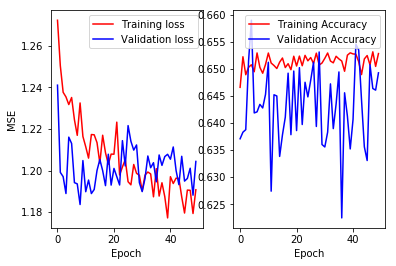

In [60]:
# Hyper-parameters
# setting hyperparameters and gettings epoch sizes
batch_size = 8
num_epochs = 50
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# Define a loss function and optimizer for this problem
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-3)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(predictions,ts)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_accs = 0
    epoch_training_iter = 0
    epoch_validation_loss = 0
    epoch_validation_accs = 0
    epoch_validation_iter = 0
    
    net.eval()
    for j in range(num_batches_valid):
        inputs = get_variable(torch.Tensor(X_valid[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_valid[j * batch_size: (j + 1) * batch_size])))
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()
        epoch_validation_accs += accuracy(outputs, targets)
        epoch_validation_iter += 1
    
    net.train()
    for j in range(num_batches_train):
        inputs = get_variable(torch.Tensor(X_train[j * batch_size: (j + 1) * batch_size]))
        targets = get_variable(torch.Tensor(np.squeeze(y_train[j * batch_size: (j + 1) * batch_size])))
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        epoch_training_accs += accuracy(outputs,targets)
        epoch_training_iter += 1
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/epoch_training_iter)
    train_accs.append(epoch_training_accs/epoch_training_iter)
    valid_loss.append(epoch_validation_loss/epoch_validation_iter)
    valid_accs.append(epoch_validation_accs/epoch_validation_iter)

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f} \t valid acc: {valid_accs[-1]:.4f}')



# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.subplot(1,2,1)
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(epoch, train_accs, 'r', label='Training Accuracy')
plt.plot(epoch, valid_accs, 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('')
plt.show()